In [1]:
import pandas as pd
import seaborn as sns
from sklearn import tree
import numpy as np
import glob, os
import matplotlib.pyplot as plt


In [2]:
PERCENTAGES = 0.25
ASCEND = False

# Listing the paramters result files

In [3]:
files = glob.glob("saved/parameters/*.txt")

In [4]:
gene = {"GSE110894":21182,"GSE112274":26982,"GSE117872":18120,"GSE140440":32197,"GSE149383":18380}
cell = {"GSE110894":1419,"GSE112274":507,"GSE117872":1302,"GSE140440":324,"GSE149383":2730}
drop = {"GSE110894":73.17,"GSE112274":71.27,"GSE117872":59.33,"GSE140440":64.22,"GSE149383":94.26}


In [5]:
def apply_sum(r,colname):
    nums = r[colname].split(",")
    return int(nums[0]) + int(nums[1])

def apply_sum_col(r,columns):
    s = 0
    for c in columns:
        s = int(r[c])+s
    return s

def apply_split_val(r,colname,sep="_bottle_",ind=1):
    return r[colname].split(",")[ind]

In [6]:
df_score = pd.read_csv(files[0],header=None,sep="\t")

In [7]:
df_score.iloc[0,0].split("_bottle_")[1]

'128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_F_lr_0.01_mod_new_sam_upsamping'

In [8]:
df_all = pd.DataFrame([])
# Read an process all files
for f in files:
    df_score = pd.read_csv(f,header=None,sep="\t")
    df_score.columns=["Param","score"]
    df_param = pd.read_csv(f,header=None,sep="_")
    
    # If the file have an extra flag of HN120
    if(df_param.shape[1] % 2 !=0):
        df_param.loc[:,1] = df_param.loc[:,1]+df_param.loc[:,2]
        df_param = df_param.drop(columns=[2])
    
    # Get column names as
    col_names = df_param.loc[0,0::2].values
    df_param_vals = df_param.loc[:,1::2]
    
    sams = [ r.split("\t")[0] for r in df_param_vals.iloc[:,-1].values]
    df_param_vals.iloc[:,-1] = sams
    df_param_vals.columns= list(col_names)
    
    
    # Add other demos
        
    df_param_vals["p_parms"] = df_param_vals.apply(apply_sum,colname="edim",axis=1)
    df_param_vals["e_parms"] = df_param_vals.apply(apply_sum,colname="pdim",axis=1)
    df_param_vals["n_parms"] = df_param_vals.apply(apply_sum_col,columns=["e_parms","p_parms","bottle"],axis=1)

    
    gse = f[17:26]
    df_param_vals["genes"] = gene[gse]
    df_param_vals["cells"] = cell[gse]
    df_param_vals["pct_drop"] = drop[gse]
    
    
    df_param_vals["all_p"] = df_param_vals["bottle"].astype(str)+df_param_vals["edim"]+df_param_vals["pdim"]+\
    df_param_vals["dropout"].astype(str)+df_param_vals["lr"].astype(str)+\
    df_param_vals["sam"]
    
    df_param_vals["params"] = df_score.Param


    
    df_param_vals["score"] =  df_score.score
    
    # Order by score
    df_param_vals.sort_values("score",inplace=True,ascending=ASCEND)   
    

    # Append the df to the main file
    if(len(df_all)==0):
        df_all = df_param_vals.head(int(len(df_param_vals)*PERCENTAGES))
    else:
        df_all = pd.concat([df_all, df_param_vals.head(int(len(df_param_vals)*PERCENTAGES))])

In [9]:
df_all

1214data       drug  bottle     edim     pdim model  dropout gene    lr  \
411  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.3    F  0.10   
1    GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.01   
12   GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.50   
363  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.01   
373  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.10   
..         ...        ...     ...      ...      ...   ...      ...  ...   ...   
68   GSE149383  ERLOTINIB      64  512,256   128,64   DAE      0.1    F  0.10   
33   GSE149383  ERLOTINIB      64  512,256   128,64   DAE      0.1    F  0.01   
93   GSE149383  ERLOTINIB     128  512,256   128,64   DAE      0.1    F  0.50   
51   GSE149383  ERLOTINIB      64  512,256  256,128   DAE      0.3    F  0.01   
75   GSE149383  ERLOTINIB      64  512,256  256,128   DAE      0.3    F  0.10   

     mod           sam  p_parms  e_parms  n_parms  genes  cells  pct_drop  \
411  new         SMOTE      768      192     1472  21182   1419     73.17   
1    new  downsampling      768      384     1280  21182   1419     73.17   
12   new  downsampling      768      384     1280  21182   1419     73.17   
363  new  downsampling      768      192     1472  21182   1419     73.17   
373  new  downsampling      768      192     1472  21182   1419     73.17   
..   ...           ...      ...      ...      ...    ...    ...       ...   
68   new            no      768      192     1024  18380   2730     94.26   
33   new     upsamping      768      192     1024  18380   2730     94.26   
93   new         SMOTE      768      192     1088  18380   2730     94.26   
51   new     upsamping      768      384     1216  18380   2730     94.26   
75   new     upsamping      768      384     1216  18380   2730     94.26   

                                    all_p  \
411           512512,256128,640.30.1SMOTE   
1    128512,256256,1280.10.01downsampling   
12    128512,256256,1280.10.5downsampling   
363   512512,256128,640.10.01downsampling   
373    512512,256128,640.10.1downsampling   
..                                    ...   
68                64512,256128,640.10.1no   
33        64512,256128,640.10.01upsamping   
93            128512,256128,640.10.5SMOTE   
51       64512,256256,1280.30.01upsamping   
75        64512,256256,1280.30.1upsamping   

                                                params     score  
411  1214data_GSE110894_drug_I.BET.762_bottle_512_e...  0.961954  
1    1214data_GSE110894_drug_I.BET.762_bottle_128_e...  0.961950  
12   1214data_GSE110894_drug_I.BET.762_bottle_128_e...  0.961950  
363  1214data_GSE110894_drug_I.BET.762_bottle_512_e...  0.952796  
373  1214data_GSE110894_drug_I.BET.762_bottle_512_e...  0.952796  
..                                                 ...       ...  
68   1214data_GSE149383_drug_ERLOTINIB_bottle_64_ed...  0.571798  
33   1214data_GSE149383_drug_ERLOTINIB_bottle_64_ed...  0.571798  
93   1214data_GSE149383_drug_ERLOTINIB_bottle_128_e...  0.567468  
51   1214data_GSE149383_drug_ERLOTINIB_bottle_64_ed...  0.565783  
75   1214data_GSE149383_drug_ERLOTINIB_bottle_64_ed...  0.565783  

[898 rows x 20 columns]

In [10]:
df = df_all[["1214data","all_p","score"]]\
.groupby(["1214data"])\
.aggregate(['min','count'])\
.reset_index()
df

1214data                                 all_p           score      
                                                    min count       min count
0       GSE110894  128256,128256,1280.10.01downsampling   119  0.782831   119
1       GSE112274              128256,128128,640.10.1no   120  0.753341   120
2  GSE117872HN120          128256,128128,640.10.01SMOTE   180  0.675309   180
3  GSE117872HN137          128256,128128,640.00.01SMOTE   240  0.531964   240
4       GSE140440          128256,128256,1280.10.5SMOTE   120  0.563209   120
5       GSE149383           128256,128128,640.10.1SMOTE   119  0.565783   119

In [11]:
df = df_all[["bottle","edim","pdim","lr","1214data","dropout","score"]]\
.groupby(["bottle","edim","pdim","lr","1214data","dropout"])\
.aggregate(['min','count'])\
.reset_index()
df

bottle     edim     pdim    lr        1214data dropout     score      
                                                                 min count
0       32  256,128   128,64  0.01       GSE112274     0.1  0.876208     2
1       32  256,128   128,64  0.01  GSE117872HN120     0.1  0.678518     2
2       32  256,128   128,64  0.01  GSE117872HN120     0.3  0.724372     1
3       32  256,128   128,64  0.01  GSE117872HN137     0.0  0.533777     3
4       32  256,128   128,64  0.01       GSE140440     0.1  0.574009     3
..     ...      ...      ...   ...             ...     ...       ...   ...
436    512  512,256  256,128  0.50  GSE117872HN137     0.0  0.571216     2
437    512  512,256  256,128  0.50       GSE140440     0.1  0.663500     2
438    512  512,256  256,128  0.50       GSE140440     0.3  0.607722     3
439    512  512,256  256,128  0.50       GSE149383     0.1  0.586736     2
440    512  512,256  256,128  0.50       GSE149383     0.3  0.773419     3

[441 rows x 8 columns]

In [12]:
df = df_all[["all_p","1214data","score"]]\
.groupby(["1214data"])\
.aggregate(['max','count'])\
.reset_index()
df

1214data                               all_p           score      
                                                  max count       max count
0       GSE110894          64512,256128,640.30.5SMOTE   119  0.961954   119
1       GSE112274            64512,256256,1280.10.5no   120  0.968739   120
2  GSE117872HN120   64512,256128,640.10.1downsampling   180  0.839172   180
3  GSE117872HN137            64512,256256,1280.10.5no   240  0.764853   240
4       GSE140440  64512,256256,1280.30.5downsampling   120  0.903917   120
5       GSE149383         64512,256256,1280.30.5SMOTE   119  0.906310   119

In [13]:
df_all.sort_values("score",ascending=False).drop_duplicates("1214data")

1214data       drug  bottle     edim     pdim model  dropout gene  \
35        GSE112274  GEFITINIB      64  512,256  256,128   DAE      0.1    F   
411       GSE110894  I.BET.762     512  512,256   128,64   DAE      0.3    F   
242       GSE149383  ERLOTINIB     512  512,256  256,128   DAE      0.1    F   
372       GSE140440  DOCETAXEL     512  256,128  256,128   DAE      0.3    F   
477  GSE117872HN120  CISPLATIN      32  256,128   128,64   DAE      0.3    F   
672  GSE117872HN137  CISPLATIN      64  256,128   128,64   DAE      0.3    F   

      lr  mod         sam  p_parms  e_parms  n_parms  genes  cells  pct_drop  \
35   0.1  new          no      768      384     1216  26982    507     71.27   
411  0.1  new       SMOTE      768      192     1472  21182   1419     73.17   
242  0.1  new       SMOTE      768      384     1664  18380   2730     94.26   
372  0.5  new          no      384      384     1280  32197    324     64.22   
477  0.5  new       SMOTE      384      192      608  18120   1302     59.33   
672  0.1  new  upsampling      384      192      640  18120   1302     59.33   

                               all_p  \
35          64512,256256,1280.10.1no   
411      512512,256128,640.30.1SMOTE   
242     512512,256256,1280.10.1SMOTE   
372        512256,128256,1280.30.5no   
477       32256,128128,640.30.5SMOTE   
672  64256,128128,640.30.1upsampling   

                                                params     score  
35   1214data_GSE112274_drug_GEFITINIB_bottle_64_ed...  0.968739  
411  1214data_GSE110894_drug_I.BET.762_bottle_512_e...  0.961954  
242  1214data_GSE149383_drug_ERLOTINIB_bottle_512_e...  0.906310  
372  1214data_GSE140440_drug_DOCETAXEL_bottle_512_e...  0.903917  
477  1214data_GSE117872_HN120_drug_CISPLATIN_bottle...  0.839172  
672  1214data_GSE117872_HN137_drug_CISPLATIN_bottle...  0.764853

In [39]:
df.dropout.mode()

min  count
0  0.0    297
1  NaN    299
2  NaN    302

In [40]:
df.sort_values(by=('score', 'min'),ascending=False)

lr bottle           edim          pdim         1214data       dropout  \
           min count      min count     min count        min count     min   
0  0.01     32   302  256,128   302  128,64   302  GSE110894   302     0.0   
1  0.10     32   299  256,128   299  128,64   299  GSE110894   299     0.0   
2  0.50     32   297  256,128   297  128,64   297  GSE110894   297     0.0   

            score        
  count       min count  
0   302  0.532951   302  
1   299  0.532679   299  
2   297  0.531964   297

In [41]:
df_all.groupby("all_p")

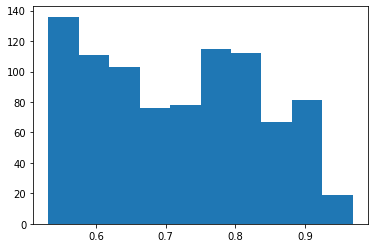

In [42]:
plt.hist(df_all.score)
plt.show()

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_theme(style="ticks")

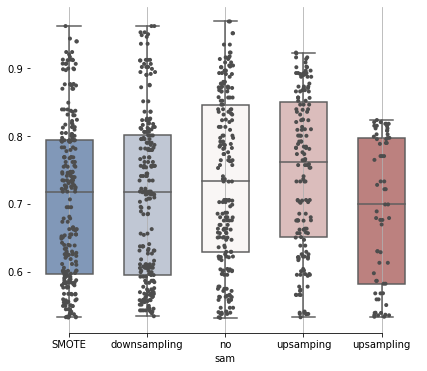

In [44]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="sam", y="score", data=df_all,
            whis=[0, 100], width=.6, palette="vlag")

# # Add in points to show each observation
sns.stripplot(x="sam", y="score", data=df_all,
              size=4, color=".3", linewidth=0)
  
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

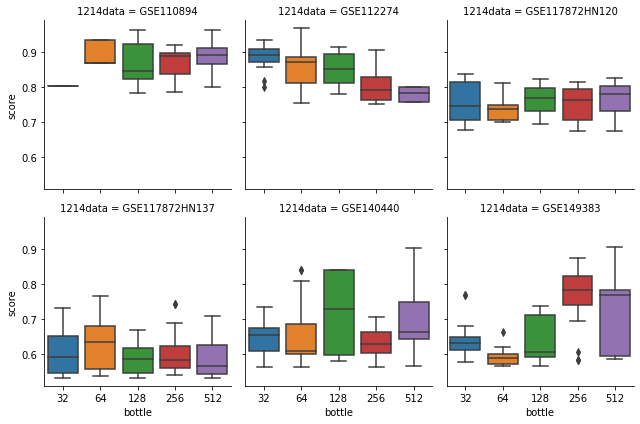

In [45]:
g = sns.catplot(x="bottle", y="score",
                #hue="1214data", 
                col="1214data",height=3, aspect=1,col_wrap=3, 
                data=df_all, kind="box");

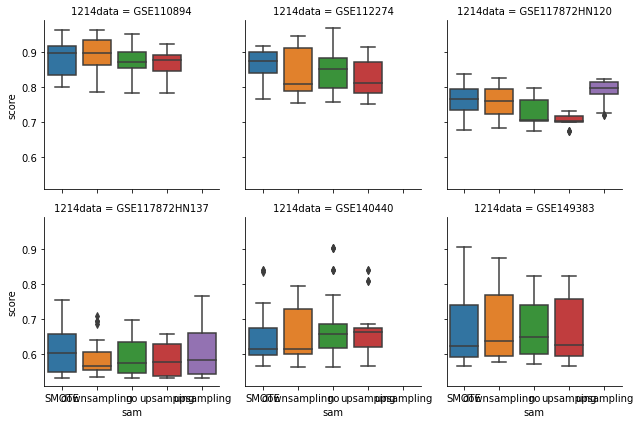

In [46]:
g = sns.catplot(x="sam", y="score",
                #hue="1214data", 
                col="1214data",height=3, aspect=1,col_wrap=3, 
                data=df_all, kind="box");

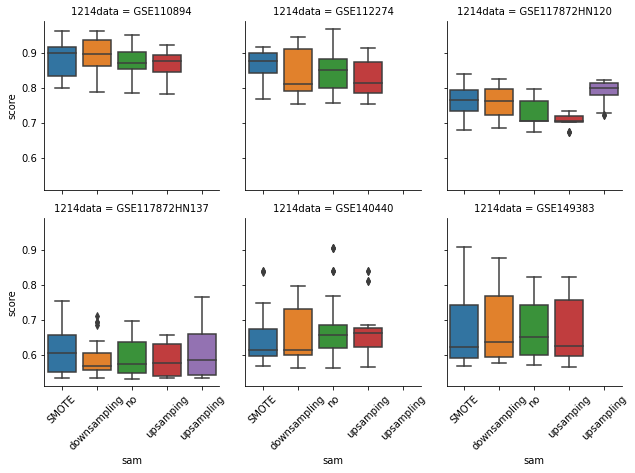

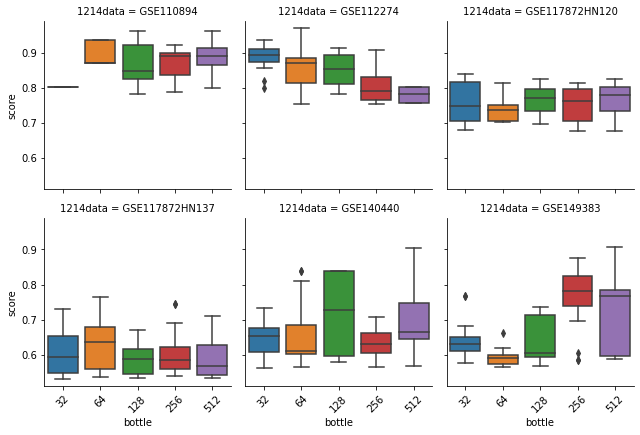

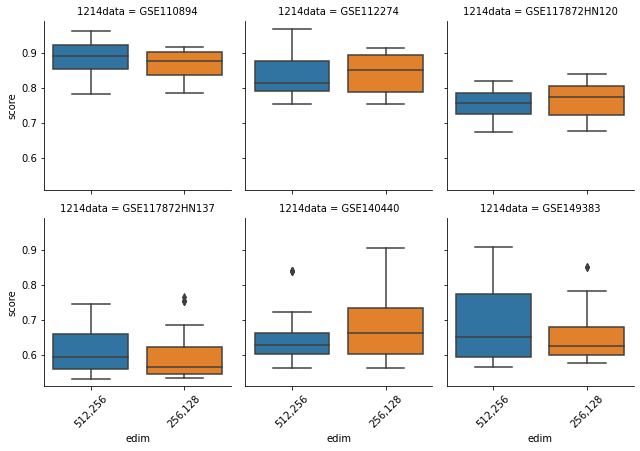

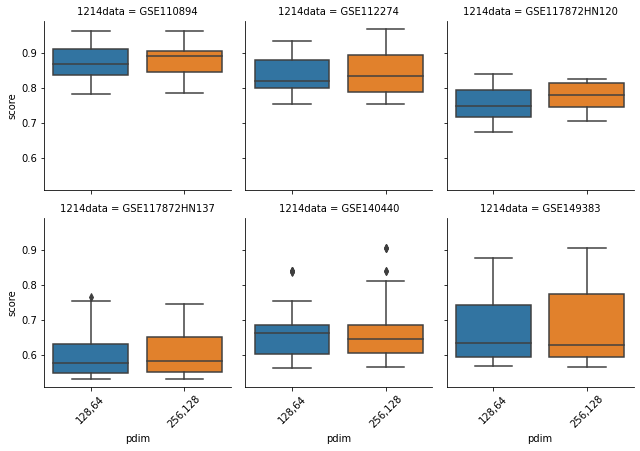

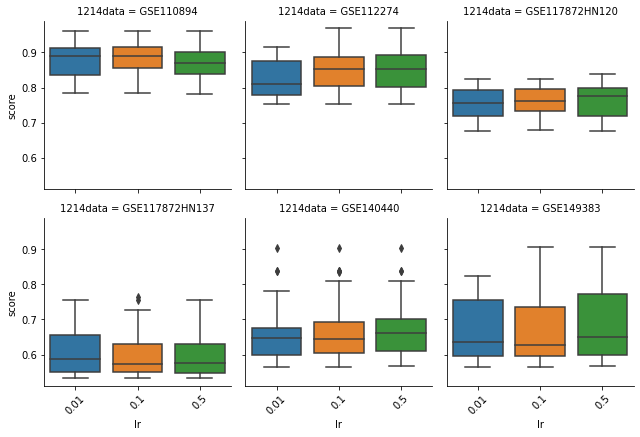

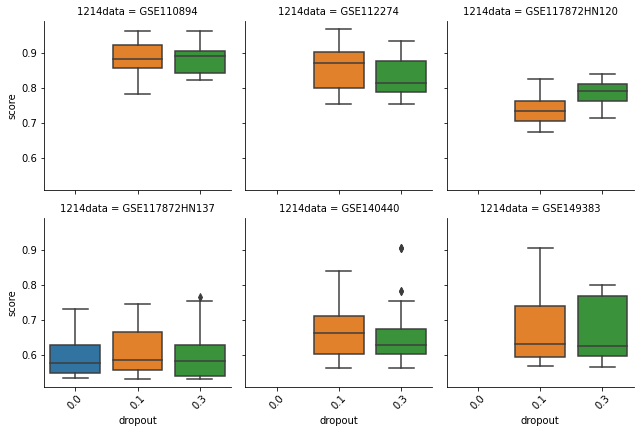

In [47]:
for p in ["sam","bottle","edim","pdim","lr","dropout"]:
    g = sns.catplot(x=p, y="score",
                #hue="1214data", 
                col="1214data",height=3, aspect=1,col_wrap=3, 
                data=df_all, kind="box");
    
    g.set_xticklabels(rotation=45)

    plt.savefig("saved/figures/params/"+p+"_parpm_box.pdf")

In [48]:
# df_score = df_score.sort_values("score",ascending=False)

In [49]:
df_score = df_all

In [50]:
df_all.columns

Index(['1214data', 'drug', 'bottle', 'edim', 'pdim', 'model', 'dropout',
       'gene', 'lr', 'mod', 'sam', 'p_parms', 'e_parms', 'n_parms', 'genes',
       'cells', 'pct_drop', 'all_p', 'score'],
      dtype='object')

In [51]:
select_params = ['bottle', 'dropout', 'lr', 'p_parms', 'e_parms', 'n_parms']

In [52]:
select_params

['bottle', 'dropout', 'lr', 'p_parms', 'e_parms', 'n_parms']

1214data       drug  bottle     edim     pdim model  dropout gene    lr  \
411  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.3    F  0.10   
1    GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.01   
12   GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.50   
363  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.01   
373  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.10   
..         ...        ...     ...      ...      ...   ...      ...  ...   ...   
68   GSE149383  ERLOTINIB      64  512,256   128,64   DAE      0.1    F  0.10   
33   GSE149383  ERLOTINIB      64  512,256   128,64   DAE      0.1    F  0.01   
93   GSE149383  ERLOTINIB     128  512,256   128,64   DAE      0.1    F  0.50   
51   GSE149383  ERLOTINIB      64  512,256  256,128   DAE      0.3    F  0.01   
75   GSE149383  ERLOTINIB      64  512,256  256,128   DAE      0.3    F  0.10   

     mod           sam  p_parms  e_parms  n_parms  genes  cells  pct_drop  \
411  new         SMOTE      768      192     1472  21182   1419     73.17   
1    new  downsampling      768      384     1280  21182   1419     73.17   
12   new  downsampling      768      384     1280  21182   1419     73.17   
363  new  downsampling      768      192     1472  21182   1419     73.17   
373  new  downsampling      768      192     1472  21182   1419     73.17   
..   ...           ...      ...      ...      ...    ...    ...       ...   
68   new            no      768      192     1024  18380   2730     94.26   
33   new     upsamping      768      192     1024  18380   2730     94.26   
93   new         SMOTE      768      192     1088  18380   2730     94.26   
51   new     upsamping      768      384     1216  18380   2730     94.26   
75   new     upsamping      768      384     1216  18380   2730     94.26   

                                    all_p     score  
411           512512,256128,640.30.1SMOTE  0.961954  
1    128512,256256,1280.10.01downsampling  0.961950  
12    128512,256256,1280.10.5downsampling  0.961950  
363   512512,256128,640.10.01downsampling  0.952796  
373    512512,256128,640.10.1downsampling  0.952796  
..                                    ...       ...  
68                64512,256128,640.10.1no  0.571798  
33        64512,256128,640.10.01upsamping  0.571798  
93            128512,256128,640.10.5SMOTE  0.567468  
51       64512,256256,1280.30.01upsamping  0.565783  
75        64512,256256,1280.30.1upsamping  0.565783  

[898 rows x 19 columns]

In [63]:
df_all

1214data       drug  bottle     edim     pdim model  dropout gene    lr  \
411  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.3    F  0.10   
1    GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.01   
12   GSE110894  I.BET.762     128  512,256  256,128   DAE      0.1    F  0.50   
363  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.01   
373  GSE110894  I.BET.762     512  512,256   128,64   DAE      0.1    F  0.10   
..         ...        ...     ...      ...      ...   ...      ...  ...   ...   
28   GSE149383  ERLOTINIB     128  512,256   128,64   DAE      0.1    F  0.01   
219  GSE149383  ERLOTINIB      32  256,128   128,64   DAE      0.1    F  0.01   
244  GSE149383  ERLOTINIB      32  256,128   128,64   DAE      0.1    F  0.10   
221  GSE149383  ERLOTINIB      32  256,128   128,64   DAE      0.1    F  0.10   
270  GSE149383  ERLOTINIB      32  256,128   128,64   DAE      0.1    F  0.50   

     mod           sam  p_parms  e_parms  n_parms  genes  cells  pct_drop  \
411  new         SMOTE      768      192     1472  21182   1419     73.17   
1    new  downsampling      768      384     1280  21182   1419     73.17   
12   new  downsampling      768      384     1280  21182   1419     73.17   
363  new  downsampling      768      192     1472  21182   1419     73.17   
373  new  downsampling      768      192     1472  21182   1419     73.17   
..   ...           ...      ...      ...      ...    ...    ...       ...   
28   new  downsampling      768      192     1088  18380   2730     94.26   
219  new            no      384      192      608  18380   2730     94.26   
244  new            no      384      192      608  18380   2730     94.26   
221  new     upsamping      384      192      608  18380   2730     94.26   
270  new            no      384      192      608  18380   2730     94.26   

                                    all_p     score  
411           512512,256128,640.30.1SMOTE  0.961954  
1    128512,256256,1280.10.01downsampling  0.961950  
12    128512,256256,1280.10.5downsampling  0.961950  
363   512512,256128,640.10.01downsampling  0.952796  
373    512512,256128,640.10.1downsampling  0.952796  
..                                    ...       ...  
28    128512,256128,640.10.01downsampling  0.688982  
219              32256,128128,640.10.01no  0.680336  
244               32256,128128,640.10.1no  0.680336  
221        32256,128128,640.10.1upsamping  0.680336  
270               32256,128128,640.10.5no  0.680336  

[238 rows x 19 columns]

In [67]:
df_all.corr()

bottle   dropout        lr   p_parms   e_parms   n_parms  \
bottle    1.000000  0.308272 -0.035774  0.154726  0.100810  0.747954   
dropout   0.308272  1.000000 -0.033293  0.026054  0.004384  0.208981   
lr       -0.035774 -0.033293  1.000000  0.015509  0.008293 -0.010109   
p_parms   0.154726  0.026054  0.015509  1.000000 -0.049454  0.697151   
e_parms   0.100810  0.004384  0.008293 -0.049454  1.000000  0.341371   
n_parms   0.747954  0.208981 -0.010109  0.697151  0.341371  1.000000   
genes    -0.254643  0.106370  0.031887 -0.249521 -0.009964 -0.315101   
cells     0.346982  0.104494  0.004973  0.243126 -0.012122  0.361712   
pct_drop  0.205784  0.340730  0.030121  0.176459 -0.020461  0.230304   
score     0.032959  0.386394 -0.035616  0.064799  0.086911  0.087290   

             genes     cells  pct_drop     score  
bottle   -0.254643  0.346982  0.205784  0.032959  
dropout   0.106370  0.104494  0.340730  0.386394  
lr        0.031887  0.004973  0.030121 -0.035616  
p_parms  -0.249521  0.243126  0.176459  0.064799  
e_parms  -0.009964 -0.012122 -0.020461  0.086911  
n_parms  -0.315101  0.361712  0.230304  0.087290  
genes     1.000000 -0.814004 -0.359353  0.080738  
cells    -0.814004  1.000000  0.785132 -0.103873  
pct_drop -0.359353  0.785132  1.000000  0.185034  
score     0.080738 -0.103873  0.185034  1.000000

In [312]:
table = pd.pivot_table(df_all, values='score', index=["1214data"],
                    columns=["all"], aggfunc=np.max)

table=table.fillna(0)
ax = sns.heatmap(table)


KeyError: 'all'

In [ ]:
for p1 in select_params:
    for p2 in select_params:
        if(p1!=p2):
            table = pd.pivot_table(df_score, values='score', index=[p1],
                                columns=[p2], aggfunc=np.max)
            
            table=table.fillna(0)
            ax = sns.heatmap(table)
            plt.savefig("saved/figures/param_ascend_"+str(ASCEND)+p1+p2+".pdf")
            plt.clf()

In [ ]:
set(df_score.iloc[:,0])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

for data in set(df_score.iloc[:,0]):
    
    df_select = df_score.loc[df_score.iloc[:,0]==data,:]
    
    X = df_select.loc[:,select_params].values
    # y = 1 * x_0 + 2 * x_1 + 3
    y = df_select.loc[:,"score"].values

    reg = RandomForestRegressor().fit(X, y)
    print(data)
    print(reg.score(X, y))

    print(reg.feature_importances_)
print(df_select.loc[:,select_params].columns)

In [ ]:
reg.estimators_[0].predict(X[0].reshape(1,-1))

In [ ]:
text_representation  = tree.export_text(reg.estimators_[0])
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)